# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called Stochastic Gradient Descent (SGD), to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop ridge regression algorithm (linear regression with $\ell_2$ regularization).

## Instructions
<ol>
	<li>Generate a synthetic dataset suitable for regression and divide it to train and test sets,
    <li>Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and termination threshold $\epsilon$.</li>
	<li> Use the above function and repeat the following until the difference between the old and new weight vectors becomes small (i.e., $d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n$</li>
</ol>
</li>
</ol>
</li>
	<li>Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$</li>
    <li>Plot the training and testing errors vs. iteration number $\tau$.</li>
    <li>Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value</li>
</ol>

## Implementation
### Dataset
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a weight vector (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

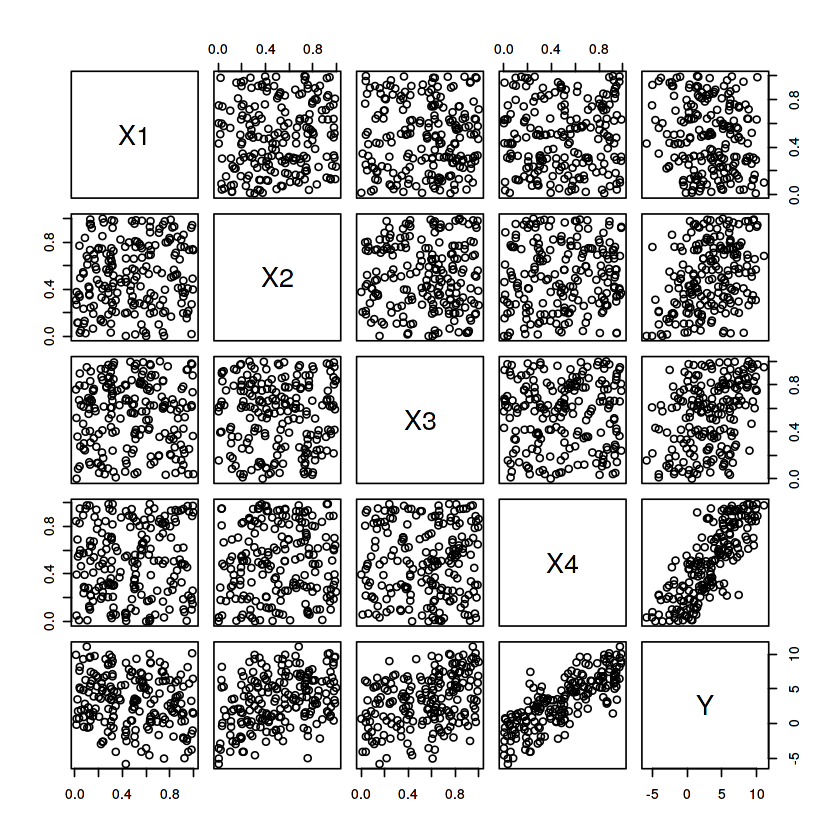

In [190]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
set.seed(1234) # to make the results of stochastic methods reproducible

# geberate N x D data samples
N <- 200 # number of all data point (test and train)
D <- 4 # number of features/attributes
data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D))

# generate the labels
coeff <- matrix(c(-5,-3,4,5,10), D+1, 1) # the real coefficient to be estimated
data <- cbind(data,'Y'=as.matrix(cbind(1,data[,1:D])) %*% coeff) # bind Y column multiplying data by transpose coeff to x columns
# add gaussian noise the labels (just to make it a little bit more challenging)
data$Y <- data$Y + rnorm(N, mean = 0, sd =1)
pairs(data)

In [ ]:
#as.matrix(cbind(1,data[,1:D]))

Now, divide the dataset into testing and training sets

In [191]:
# divide data into training and testing sets
train.len <- N/2
train.index <- sample(1:N,train.len)
train.data <- data[train.index,  1:D]
train.label <- data[train.index, 'Y']
test.data <- data[-train.index, 1:D]
test.label <- data[-train.index, 'Y']

## Implementation
Now, based on the instruction, we initialize the parameter values.

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

In [192]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w) #phi x w_transpose # this will solve basically give us the model predictions 
    # which are w x Phi switched around because of matrix dimensions
} 

# auxiliary function to calculate a cost function
error_func <- function (Phi, w, label){
    return(sum((predict_func(Phi, w) - label)^2)/2)
}

### Initialization

In [11]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as X_0

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

#create empty W matrix (no.of iterations x no. of phi's /basis function terms) (stores coeff
# for each iteration)
W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients

W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?) uses uniform distribution
#create single column to store errors for each iteration (for graphing/tracking convergence)
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

### Main Loop

In [17]:
while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    #shuffling data part is for Stochastic part
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index] # (training labels)
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria: at each sampling can converge inside an iteration
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        #predict a label based on current coeffs (w's) (current iteration row) and single phi row/datapoint
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient (for this iteration's row):
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error: # use phi x W as per predictions and comapre with test and train labels
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter: (i.e. new iteration)
        tau <- tau + 1        
    }
}
#melt error for visualisations
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.920282 -3.315207 4.263951 4.809647 9.950755

### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

Warning message:
“Removed 2 rows containing missing values (geom_path).”

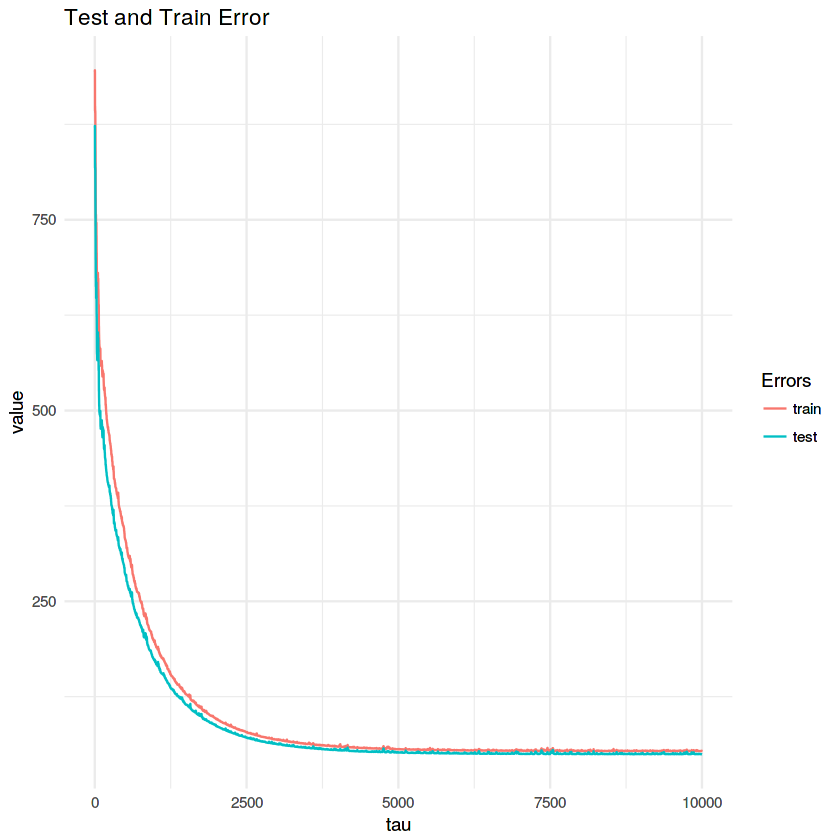

In [18]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()
  

Now let's plot the elements of the learned weight vectors over the training iterations.

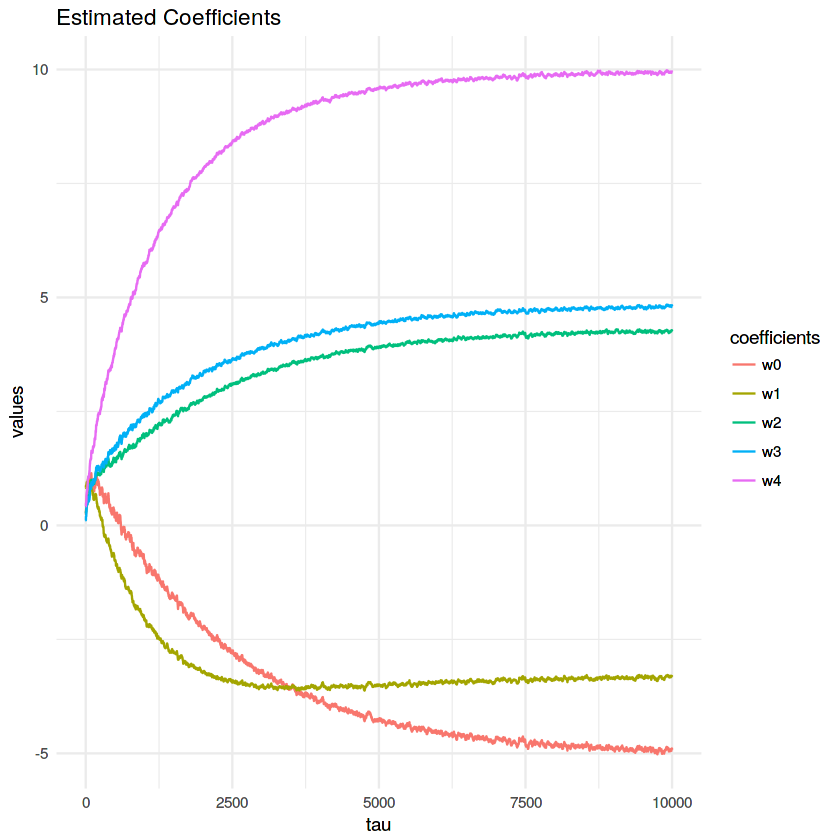

In [19]:
W.m <- as.data.frame(W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()

## Discussions
<ol>

	<li>How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.</li>
	<li>Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).</li>
	<li>Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD. </li>
</ol>

1.- How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.

In [91]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as X_0

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
for (eta in c(0.001,0.005,0.01,0.05,0.1,0.5,0.75)) {
#eta <- 0.01 # learning rate
#epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)
    epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

#create empty W matrix (no.of iterations x no. of phi's /basis function terms) (stores coeff
# for each iteration)
W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients

W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?) uses uniform distribution
#create single column to store errors for each iteration (for graphing/tracking convergence)
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE


while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    #shuffling data part is for Stochastic part
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index] # (training labels)
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria: at each sampling can converge inside an iteration
        
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        #predict a label based on current coeffs (w's) (current iteration row) and single phi row/datapoint
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient (for this iteration's row):
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error: # use phi x W as per predictions and comapre with test and train labels
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter: (i.e. new iteration)
        tau <- tau + 1        
    }
}
#melt error for visualisations
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('\n\nLearning rate Eta',eta)
cat('\nThe  real coefficents are:',coeff,'\nThe  final coefficents are:',w)
cat('\nIterations taken:',tau,'Error:',error.m[tau-1,'value'])

}

[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE
[1] FALSE


2.- Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).

It would be best to use a large value of learning rate initially then we can reduce it rapidly to get fine adjustments to the coeff rather than overshooting the real coeffecients

In [112]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as X_0

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
#for (eta in c(0.001,0.005,0.01,0.05,0.1,0.5,0.75)) {
for (a in c(1,5,10,50,100,500,1000)) { #
for (b in a*c(0.01,0.1,1,10,100,1000,10000)) { #
#for (a in c(100,250,500,750,1000)) {
#for (b in c(100,250,500,750,1000)) {
#a = 1000
#b = 100

#for (eta in c(0.5,0.75)) {
#eta <- 0.01 # learning rate
#eta_base = eta
    #epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)
epsilon <- 55 # a threshold on the cost (to terminate the process)
    
    
#create empty W matrix (no.of iterations x no. of phi's /basis function terms) (stores coeff
# for each iteration)
W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients

W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?) uses uniform distribution
#create single column to store errors for each iteration (for graphing/tracking convergence)
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE


while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    eta <- a/ (b+tau)
    #shuffling data part is for Stochastic part
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index] # (training labels)
    #print (W[tau,])
    #print (T)
   #print (Phi)
    #cat('\nLearning rate Eta',eta)
    #cat('\nPred',predict_func(Phi, W[tau,])) 
    #cat('\nError',error_func(Phi, W[tau,],T))
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria: at each sampling can converge inside an iteration
        #cat('\ntau =',tau)
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon | mean(predict_func(Phi, W[tau,])) >1e200 ) {terminate<-TRUE;break}
        #predict a label based on current coeffs (w's) (current iteration row) and single phi row/datapoint
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient (for this iteration's row):
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error: # use phi x W as per predictions and comapre with test and train labels
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter: (i.e. new iteration)
        tau <- tau + 1
        
    }
}
#melt error for visualisations
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('\n\nLearning rate Eta',eta)
cat(' a = ',a, ' b = ',b)
cat('\nThe  real coefficents are:',coeff,'\nThe  final coefficents are:',w)
cat('\nIterations taken:',tau,'Error:',error.m[tau-1,'value'])

}
}
#}
#}




Learning rate Eta 0.0001009998 a =  1  b =  0.01
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: 818852.1 85276.62 -283645.7 -721030.9 -580291.1
Iterations taken: 10000 Error: 4.192585e+12

Learning rate Eta 0.0001009989 a =  1  b =  0.1
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -49.56264 58.656 34.55275 109.5641 -107.8288
Iterations taken: 10000 Error: 127905.7

Learning rate Eta 0.0001009897 a =  1  b =  1
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -5.281385 -3.661883 3.54348 5.611664 10.8045
Iterations taken: 10000 Error: 62.36484

Learning rate Eta 0.000100898 a =  1  b =  10
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -1.27259 -2.97358 2.237742 2.958353 6.692022
Iterations taken: 10000 Error: 138.0724

Learning rate Eta 9.999e-05 a =  1  b =  100
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: 0.1658742 -0.9334755 1.382255 1.940558 3.931395
Iterations taken: 10

ratio of a = 1: b = 1000 seems to cause issues with divergence when a goes above 100 we get predictions in the 1e200+ which we have set a breakpoint to prevent the model from breaking as we get infinite error.

Best model performance with a/ (b+tau) learning rate
Learning rate Eta 0.08926977 a =  500  b =  5000
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.468437 -3.468477 4.099078 4.576367 9.648856
Iterations taken: 603 Error: 56.18997




Learning rate Eta 0.08926977 a =  500  b =  5000
The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.6538 -3.710223 4.099718 4.946822 9.807242
Iterations taken: 681 Error: 57.01744

Warning message:
“Removed 2 rows containing missing values (geom_path).”Warning message:
“Removed 46595 rows containing missing values (geom_path).”

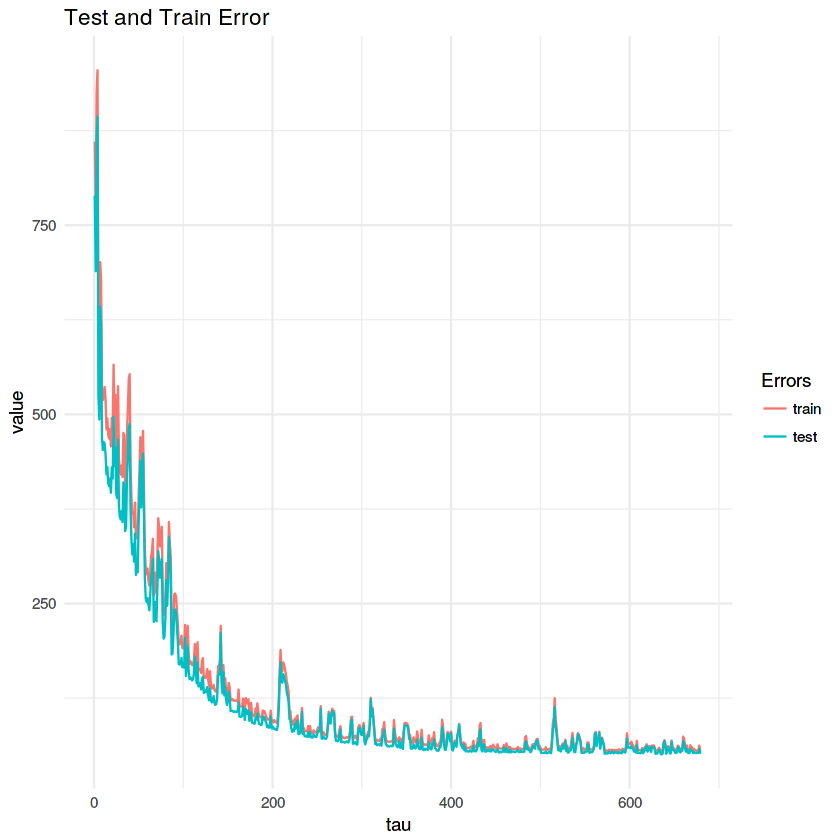

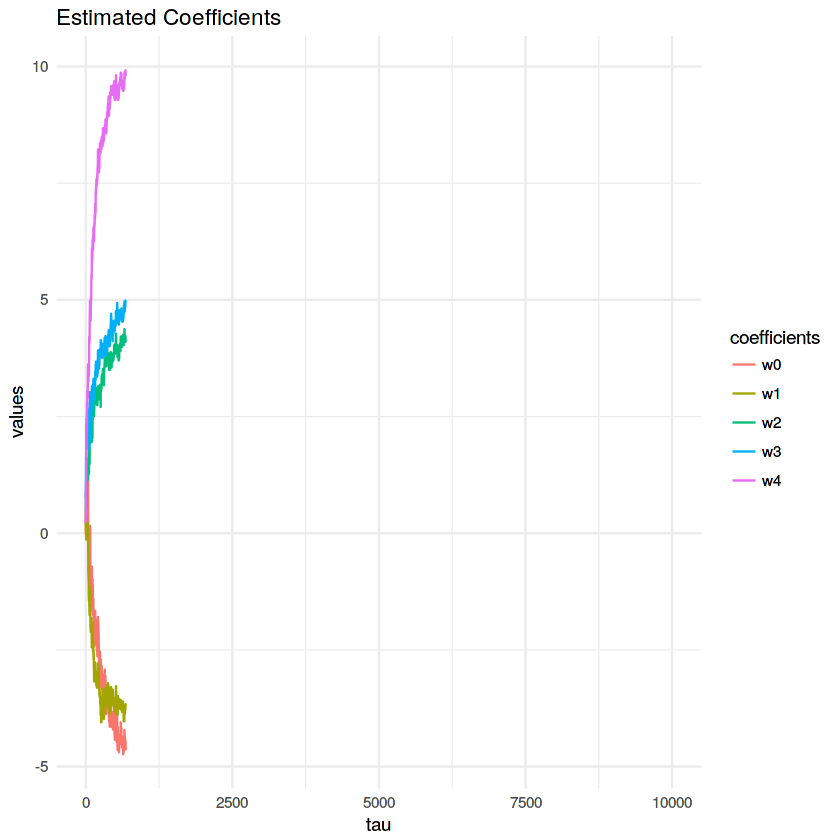

In [114]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as X_0

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
#for (eta in c(0.001,0.005,0.01,0.05,0.1,0.5,0.75)) {
#for (a in c(1,5,10,50,100,500,1000)) { #
#for (b in a*c(0.01,0.1,1,10,100,1000,10000)) { #
#for (a in c(100,250,500,750,1000)) {
#for (b in c(100,250,500,750,1000)) {
a = 500
b = 5000

#for (eta in c(0.5,0.75)) {
#eta <- 0.01 # learning rate
#eta_base = eta
    #epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)
epsilon <- 55 # a threshold on the cost (to terminate the process)
    
    
#create empty W matrix (no.of iterations x no. of phi's /basis function terms) (stores coeff
# for each iteration)
W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients

W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?) uses uniform distribution
#create single column to store errors for each iteration (for graphing/tracking convergence)
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE


while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    eta <- a/ (b+tau)
    #shuffling data part is for Stochastic part
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index] # (training labels)

    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria: at each sampling can converge inside an iteration
        #cat('\ntau =',tau)
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon | mean(predict_func(Phi, W[tau,])) >1e200 ) {terminate<-TRUE;break}
        #predict a label based on current coeffs (w's) (current iteration row) and single phi row/datapoint
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient (for this iteration's row):
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error: # use phi x W as per predictions and comapre with test and train labels
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter: (i.e. new iteration)
        tau <- tau + 1
        
    }
}
#melt error for visualisations
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('\n\nLearning rate Eta',eta)
cat(' a = ',a, ' b = ',b)
cat('\nThe  real coefficents are:',coeff,'\nThe  final coefficents are:',w)
cat('\nIterations taken:',tau,'Error:',error.m[tau-1,'value'])

#}
#}
#}
#}
print(ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal())
W.m <- as.data.frame(W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')

print(ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal())

3.- Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD. 

In [269]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as X_0

T <- train.label # rename just for conviniance
tau.max <- 1000 # maximum number of iterations
#eta <- 0.01 # learning rate
eta <- 0.01 # learning rate
eta0 <- eta
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

#create empty W matrix (no.of iterations x no. of phi's /basis function terms) (stores coeff
# for each iteration)
W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients

W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?) uses uniform distribution
#create single column to store errors for each iteration (for graphing/tracking convergence)
error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE


while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    #shuffling data part is for Stochastic part
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index] # (training labels)
    
    # for each datapoint:
    #for (i in 1:train.len){
        # check termination criteria: at each sampling can converge inside an iteration
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        #predict a label based on current coeffs (w's) (current iteration row) and single phi row/datapoint
        t_pred = predict_func(Phi, W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient (for this iteration's row):
            if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
            W[(tau+1),j] <- W[tau,j] + eta * (Phi[,j] %*%(T-t_pred) )
        }
        
        # record the error: # use phi x W as per predictions and comapre with test and train labels
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        error1 <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        if (abs((error1 - error0)/error0)<=0.0000005) {terminate<-TRUE;break}
        error0 <- error1
    print (error1)
        # update the counter: (i.e. new iteration)
        tau <- tau + 1  
    if (error0 > (mean(T)*30)) {
    eta <- eta*0.99
        }
    else
        {
        eta <- max(eta*0.7,0.005)
    }

}
#melt error for visualisations
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)
cat('\nIteration No.:',tau)

[1] 732.1363
[1] 667.7047
[1] 617.2931
[1] 576.3398
[1] 540.7814
[1] 507.2575
[1] 473.3224
[1] 437.5858
[1] 399.7219
[1] 360.3248
[1] 320.6303
[1] 282.1656
[1] 246.4034
[1] 214.4912
[1] 187.0994
[1] 164.396
[1] 146.1244
[1] 131.7385
[1] 120.5523
[1] 111.8666
[1] 105.0556
[1] 99.61007
[1] 95.14546
[1] 91.38823
[1] 88.91092
[1] 87.07689
[1] 85.35908
[1] 83.74049
[1] 82.21453
[1] 80.77515
[1] 79.41671
[1] 78.13402
[1] 76.92225
[1] 75.77692
[1] 74.6939
[1] 73.66931
[1] 72.69957
[1] 71.78136
[1] 70.91156
[1] 70.08729
[1] 69.30585
[1] 68.56475
[1] 67.86163
[1] 67.19431
[1] 66.56075
[1] 65.95905
[1] 65.38741
[1] 64.84416
[1] 64.32774
[1] 63.83668
[1] 63.36961
[1] 62.92524
[1] 62.50235
[1] 62.09981
[1] 61.71654
[1] 61.35154
[1] 61.00386
[1] 60.67262
[1] 60.35696
[1] 60.0561
[1] 59.76929
[1] 59.49582
[1] 59.23503
[1] 58.9863
[1] 58.74902
[1] 58.52263
[1] 58.30661
[1] 58.10045
[1] 57.90367
[1] 57.71583
[1] 57.53649
[1] 57.36525
[1] 57.20173
[1] 57.04556
[1] 56.8964
[1] 56.75391
[1] 56.61779
[1] 